This notebook evaluates performance of flat vs. hierarchical SVM models as a function of ontology depth. The objectives are to: 

(1) See which levels might benefit from increased (SVM) regularization<br>
(2) Evaluate the the asymptotic performance of flat vs. hierarchical models as the ontology depth increases

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sys
import re
sys.path.append('../')
data_path = '../data/'
model_path = '../models/'
from icd9 import *
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams.update({'font.size': 14, 'axes.titlesize': 14,
                     'figure.titlesize': 14})

In [2]:
data = pd.read_csv(f'{data_path}restricted_mimic_iii/labeled_notes.csv')

In [3]:
# Use basic text cleaning functions from reference book
# Citation: Python Machine Learning 2nd Edition, Raschka
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

def tokenize(text):
    return text.split()

In [4]:
# Preprocess all text
data['text'] = data['text'].apply(preprocessor)

In [5]:
# Instantiate ICD-9 tree but hold off on index for now
tree = ICD9Tree(f'{data_path}node_desc.csv', f'{data_path}node_parent.csv')

In [6]:
# Get distribution of depth of original labels
count_per_level = defaultdict(int)
unique_per_level = defaultdict(set)
all_codes = data['fcode'].copy()
all_codes.fillna('', inplace=True)
all_codes = all_codes.str.split(';').apply(set)

for all_code in all_codes:
    for code in all_code:
        count_per_level[tree.get_node(code).depth] += 1
        unique_per_level[tree.get_node(code).depth].add(code)

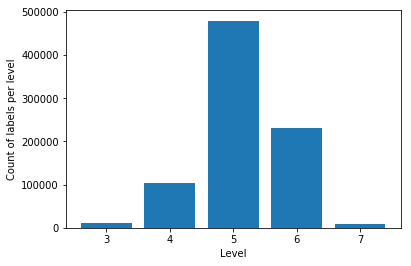

In [7]:
# Plot counts per level
levels = []
counts = []
for level, count in count_per_level.items():
    levels.append(level)
    counts.append(count)
    
plt.bar(levels, counts)
plt.xlabel('Level')
plt.ylabel('Count of labels per level')
plt.show()

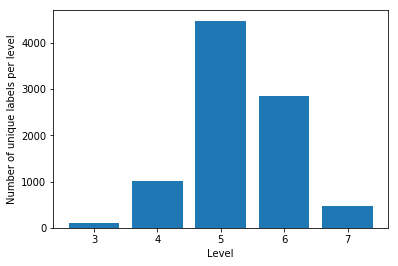

In [8]:
# Plot unique codes per level
levels = []
unique = []
for level, num_unique in unique_per_level.items():
    levels.append(level)
    unique.append(len(num_unique))
    
plt.bar(levels, unique)
plt.xlabel('Level')
plt.ylabel('Number of unique labels per level')
plt.show()

The second plot is of some use, but I really want to have this plot after mapping all labels up to each level. I will do that know to show what I mean. 

In [9]:
# This helper takes a series of sets of labels and maps to labels at
# a maximum depth in the ICD-9 ontology
def max_depth_labels(labels, max_depth, tree):
    """Helper for remapping labels to a maximum depth.
    
    labels : pandas Series of sets
        A series containing sets of labels.
    max_depth : int
        The maximum depth to map labels to.
    tree : ICD9Tree object
        A tree object used for mapping nodes to ancestors. 
    """
    # Buils a label-ancestor map for efficiency 
    temp_map = {}
    results = []
    for label_set in labels:
        temp_set = set()
        for label in label_set:
            if label in temp_map:
                temp_set.add(temp_map[label])
            else:
                temp_node = tree.get_node(label)
                while temp_node.depth > max_depth:
                    temp_node = temp_node.parent
                temp_map[label] = temp_node.code
                temp_set.add(temp_node.code)
        results.append(temp_set)
        
    return pd.Series(results)

The minimum label depth is 3, maximum is 7. I will try running models with depths of 1 through 7. 

In [10]:
for i in range(1,8):
    data[f'depth_{i}'] = max_depth_labels(all_codes, i, tree)

Now, I will revisit the number of unique labels at varying maximum depth levels. 

In [12]:
unique_per_max_depth = dict()
for i in range(1,8):
    temp_num_unique = set()
    for label_set in data[f'depth_{i}']:
        temp_num_unique = temp_num_unique.union(label_set)
    unique_per_max_depth[i] = len(temp_num_unique)

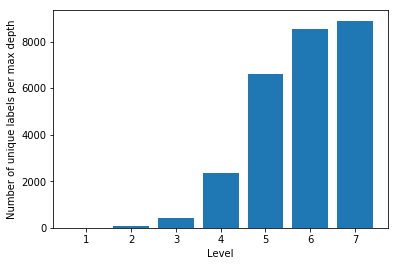

In [13]:
# Plot unique codes per level
levels = []
unique = []
for level, num_unique in unique_per_max_depth.items():
    levels.append(level)
    unique.append(num_unique)
    
plt.bar(levels, unique)
plt.xlabel('Level')
plt.xticks(levels)
plt.ylabel('Number of unique labels per max depth')
plt.show()

The growth factor is large until level 6 where the splitting is overcome by the increasingly small number of labels at the next depth. 

Finally, I would like to see how the distribution of samples per unique code varies as a function of maximum depth.

In [14]:
def samples_per_label(labels):
    """Counts samples per label in labels"""
    temp_counts = defaultdict(int)
    for label_set in labels:
        for label in label_set:
            temp_counts[label] += 1
    return temp_counts.values()

num_samples_per_label = []
for i in range(1,8):
    num_samples_per_label.append(samples_per_label(data[f'depth_{i}']))

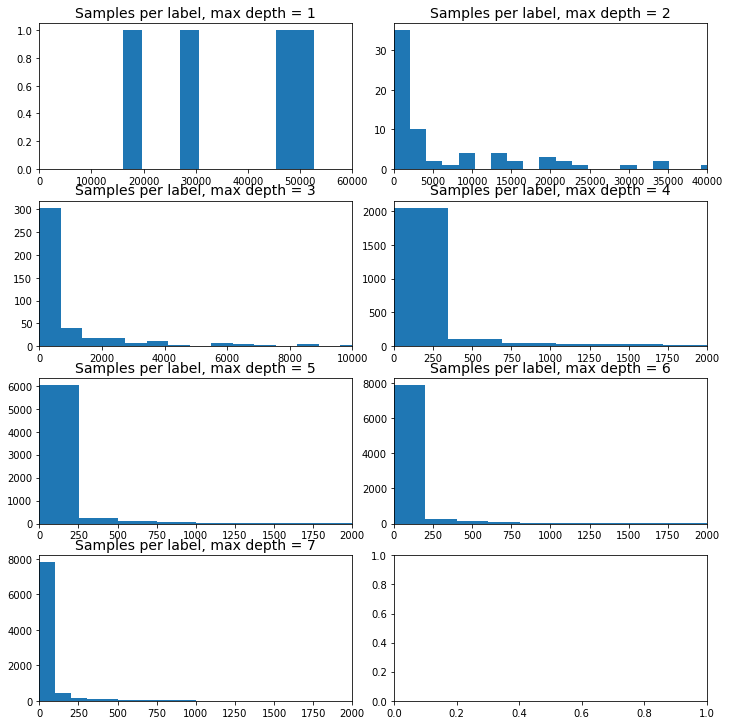

In [15]:
fig, axs = plt.subplots(4, 2, figsize=(10,10))
fig.tight_layout()
bins = [10, 20, 40, 60, 80, 100, 200]
x_lim = [60000, 40000, 10000, 2000, 2000, 2000, 2000]
for i, ax in zip(range(7), axs.flat):
    ax.hist(num_samples_per_label[i], bins=bins[i])
    ax.set_title(f"Samples per label, max depth = {i+1}")
    ax.set_xlim(0,x_lim[i])
plt.show()

The plots above show that the number of labels with very few samples grows quickly from levels 3 to 5. Here are further truncated histograms looking at only the range of 0 to 100 samples.

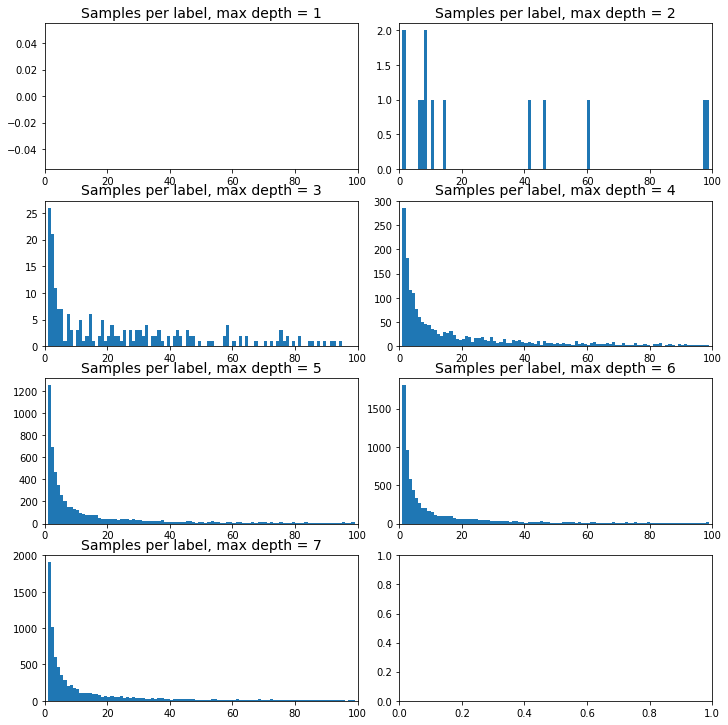

In [16]:
fig, axs = plt.subplots(4, 2, figsize=(10,10))
fig.tight_layout()
bins = [i for i in range(100)]
for i, ax in zip(range(7), axs.flat):
    ax.hist(num_samples_per_label[i], bins=bins)
    ax.set_title(f"Samples per label, max depth = {i+1}")
    ax.set_xlim(0,100)
plt.show()

This more granular view further shows how many labels correspond to increasingly few samples with an increased maximum depth.

Now, I will continue by evaluating flat vs. hierarchical model performance with varying maximum depth levels.

For now, I will follow Perotte 2014 and use only the top 10,000 most frequent unigrams with tfidf weighting.

In [17]:
# Next, fit tfidf to training data and transform other splits
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english',
                                   tokenizer=tokenize,
                                   ngram_range=(1,1),
                                   max_features=10000)

train_data = data.loc[data['split']=='train',:].reset_index()
val_data = data.loc[data['split']=='val',:].reset_index()
test_data = data.loc[data['split']=='test',:].reset_index()

train_X = tfidf_vectorizer.fit_transform(train_data['text'].values)
val_X = tfidf_vectorizer.transform(val_data['text'].values)
test_X = tfidf_vectorizer.transform(test_data['text'].values)

### Fitting and evaluating hierarchical models at varying depths

The code below fits (or loads if pretrained) hierarchical models at varying depths and computes the evaluation metrics for each one.

In [18]:
# Function for comparing flat and hierarchical models
def flat_v_hier_eval(df, h_preds, f_preds, codes='fcode', title='',
                     verbose=True):
    """Helper for evaluating flat v. hierarchical models.
    
    df : pandas DataFrame
        The evaluation set features and true labels.
    h_preds : list of lists of code Strings
        Labels predicted by the hierarchical model.
    f_preds : list of lists of code Strings
        Labels predicted by the flat model.
    codes : String
        The name of the column containing the codes as ";" delimited
        String.
    title : String
        A title for the comparison.
    """
    df['h_preds'] = pd.Series(h_preds).apply(set)
    df['f_preds'] = pd.Series(f_preds).apply(set)

    df['h_match'] = 0
    df['f_match'] = 0

#     df[codes].fillna('', inplace=True)
#     df[codes] = df[codes].str.split(';').apply(set)
    df['fcode'] = df[codes]

    for idx, row in df.iterrows():
        df.loc[idx, 'h_match'] = len(row.fcode.intersection(row.h_preds))

    for idx, row in df.iterrows():
        df.loc[idx, 'f_match'] = len(row.fcode.intersection(row.f_preds)) 
        
    def f1_score(prec, recall):
        """Compute f1 score
        
        Source: https://en.wikipedia.org/wiki/F1_score
        """
        return 2 * (prec * recall)/(prec + recall)

    h_prec = df['h_match'].sum() / df['h_preds'].apply(len).sum()
    h_recall = df['h_match'].sum() / df['fcode'].apply(len).sum()

    f_prec = df['f_match'].sum() / df['f_preds'].apply(len).sum()
    f_recall = df['f_match'].sum() / df['fcode'].apply(len).sum()

    if verbose:
        print(title)
        print(f'Flat micro-avg metrics: precision = {f_prec:.2f}, recall = {f_recall:.2f}, f1 = {f1_score(f_prec, f_recall):.2f}')
        print(f'Hierarchical micro-avg metrics: precision = {h_prec:.2f}, recall = {h_recall:.2f}, f1 = {f1_score(h_prec, h_recall):.2f}')
    
    return h_prec, h_recall, f_prec, f_recall

In [19]:
def fit_eval_at_depth(train_X, val_X, train_data, val_data, max_depth,
                      model_path, data_path, pretrained=False,
                      verbose=True):
    """Fits an SVM ensemble and prints evaluation metrics
    
    train_X : tfidf matrix
        Preprocessed training set tfidf features
    val_X : tfidf matrix
        Preprocessed validation set tfidf features
    train_data : pandas DataFrame
        pandas DataFrame containing all of the max depth labels.
    val_data : pandas DataFrame
        pandas DataFrame containing all of the max depth labels
    max_depth : int
        Maximum code depth to fit and evaluate at.
    model_path : String
        Base path for either saving or loading models.
    data_path : String
        File path with the tree construction data.
    pretrained : bool
        Whether to save or load models. 
    """
    tree = ICD9Tree(f'{data_path}node_desc.csv', f'{data_path}node_parent.csv')
    tree.index_df(train_data, codes=f'depth_{max_depth}', code_format='set')
    test_node = tree.root
    if pretrained:
        tree.load_models(model_path+'md'+str(max_depth)+'_hsvm_C1.obj',
                         model_type = 'h')
        tree.load_models(model_path+'md'+str(max_depth)+'_fsvm_C1.obj',
                         model_type = 'f')
    else:
        tree.fit_hmodel(train_X, test_node, max_depth=None)
        tree.save_models(model_path+'md'+str(max_depth)+'_hsvm_C1.obj',
                         model_type='h')
        tree.fit_fmodel(train_X, test_node, max_depth=None)
        tree.save_models(model_path+'md'+str(max_depth)+'_fsvm_C1.obj',
                         model_type='f')
        
    h_preds_train = tree.predict_hmodel(train_X, test_node)
    h_preds_val = tree.predict_hmodel(val_X, test_node)
    
    f_preds_train = tree.predict_fmodel(train_X, test_node)
    f_preds_val = tree.predict_fmodel(val_X, test_node)
    
    # Training set eval
    train_metrics = flat_v_hier_eval(train_data, h_preds_train, f_preds_train,
                                     codes=f'depth_{max_depth}',
                                     title=f'Training; Max. Depth {max_depth}',
                                     verbose=verbose)
    
    # Validation set eval
    val_metrics = flat_v_hier_eval(val_data, h_preds_val, f_preds_val,
                                   codes=f'depth_{max_depth}',
                                   title=f'Validation; Max. Depth {max_depth}',
                                   verbose=verbose)
    
    return [max_depth] + list(train_metrics) + list(val_metrics)

In [20]:
# Evaluate models at max depth of 1 through 6
results = []
for i in range(1,7):
    results.append(fit_eval_at_depth(train_X, val_X, train_data,
                                     val_data, i, model_path,
                                     data_path, pretrained=True))

Training; Max. Depth 1
Flat micro-avg metrics: precision = 0.94, recall = 0.92, f1 = 0.93
Hierarchical micro-avg metrics: precision = 0.94, recall = 0.92, f1 = 0.93
Validation; Max. Depth 1
Flat micro-avg metrics: precision = 0.89, recall = 0.87, f1 = 0.88
Hierarchical micro-avg metrics: precision = 0.89, recall = 0.87, f1 = 0.88
Training; Max. Depth 2
Flat micro-avg metrics: precision = 0.90, recall = 0.76, f1 = 0.82
Hierarchical micro-avg metrics: precision = 0.88, recall = 0.78, f1 = 0.83
Validation; Max. Depth 2
Flat micro-avg metrics: precision = 0.82, recall = 0.66, f1 = 0.73
Hierarchical micro-avg metrics: precision = 0.79, recall = 0.68, f1 = 0.73
Training; Max. Depth 3
Flat micro-avg metrics: precision = 0.90, recall = 0.65, f1 = 0.76
Hierarchical micro-avg metrics: precision = 0.85, recall = 0.72, f1 = 0.78
Validation; Max. Depth 3
Flat micro-avg metrics: precision = 0.81, recall = 0.49, f1 = 0.61
Hierarchical micro-avg metrics: precision = 0.73, recall = 0.56, f1 = 0.63
Trai

In [21]:
# Convert to DataFrame and Generate Summary Plots
results_df = pd.DataFrame(results, columns=['max_depth', 'h_prec_train', 'h_rec_train',
                                            'f_prec_train', 'f_rec_train',
                                            'h_prec_val', 'h_rec_val',
                                            'f_prec_val', 'f_rec_val'])
results_df['h_f1_train'] = 0
results_df['f_f1_train'] = 0
results_df['h_f1_val'] = 0
results_df['f_f1_val'] = 0

def f1_score(prec, recall):
    """Compute f1 score

    Source: https://en.wikipedia.org/wiki/F1_score
    """
    return 2 * (prec * recall)/(prec + recall)

for idx, row in results_df.iterrows():
    results_df.loc[idx, 'h_f1_train'] = f1_score(row.h_prec_train, row.h_rec_train)
    results_df.loc[idx, 'f_f1_train'] = f1_score(row.f_prec_train, row.f_rec_train)
    results_df.loc[idx, 'h_f1_val'] = f1_score(row.h_prec_val, row.h_rec_val)
    results_df.loc[idx, 'f_f1_val'] = f1_score(row.f_prec_val, row.f_rec_val)

In [22]:
results_df.head()

,max_depth,h_prec_train,h_rec_train,f_prec_train,f_rec_train,h_prec_val,h_rec_val,f_prec_val,f_rec_val,h_f1_train,f_f1_train,h_f1_val,f_f1_val
0,1,0.944250,0.922848,0.944250,0.922848,0.893011,0.872497,0.893011,0.872497,0.933427,0.933427,0.882635,0.882635
1,2,0.879720,0.784183,0.897203,0.762754,0.791790,0.677571,0.820105,0.655021,0.829209,0.824534,0.730241,0.728326
2,3,0.847884,0.721433,0.902099,0.650065,0.725909,0.556659,0.809996,0.491707,0.779564,0.755620,0.630117,0.611938
3,4,0.772028,0.685233,0.838972,0.579803,0.614028,0.454828,0.720483,0.367778,0.726045,0.685716,0.522572,0.486975
4,5,0.738600,0.652238,0.806091,0.511175,0.531277,0.368242,0.645033,0.263552,0.692738,0.625620,0.434985,0.374207


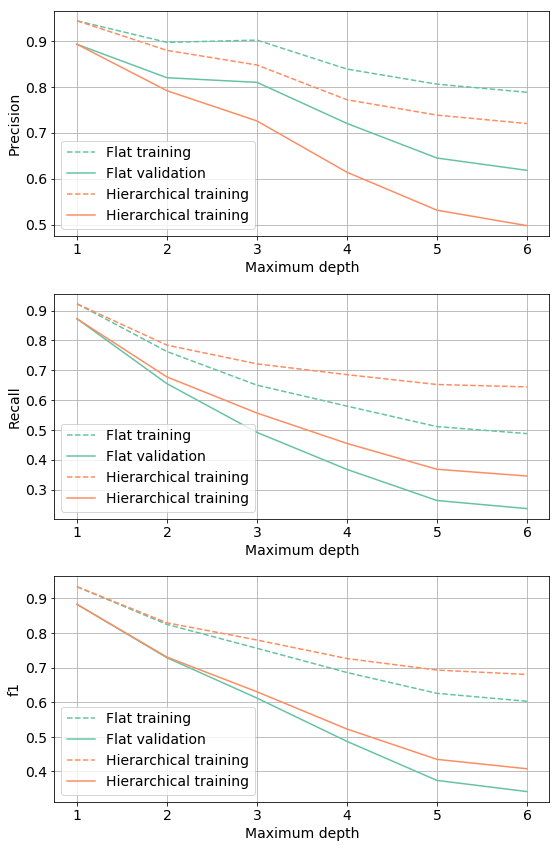

In [23]:
def subplot_helper(ax, metric, x, f_train, f_val, h_train, h_val):
    # Credit: http://colorbrewer2.org/#type=qualitative&scheme=Set2&n=3
    colors = ['#66c2a5','#fc8d62','#8da0cb']
    ax.plot(x, f_train, color=colors[0], linestyle='--', label='Flat training')
    ax.plot(x, f_val, color=colors[0], label='Flat validation')
    ax.plot(x, h_train, color=colors[1], linestyle='--', label='Hierarchical training')
    ax.plot(x, h_val, color=colors[1], label='Hierarchical training')
    ax.set_xlabel('Maximum depth')
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid()

fig, axs = plt.subplots(3,1, figsize=(8,12))
subplot_helper(axs[0], 'Precision', results_df.max_depth, results_df.f_prec_train, results_df.f_prec_val,
               results_df.h_prec_train, results_df.h_prec_val)
subplot_helper(axs[1], 'Recall', results_df.max_depth, results_df.f_rec_train, results_df.f_rec_val,
               results_df.h_rec_train, results_df.h_rec_val)
subplot_helper(axs[2], 'f1', results_df.max_depth, results_df.f_f1_train, results_df.f_f1_val,
               results_df.h_f1_train, results_df.h_f1_val)
fig.tight_layout()
plt.show()

In general, the performance difference between the flat and hierarchical models increases with depth. The flat model has an advantage in precision, while the hierarchical model has an advantage in recall and f1. Prior authors have argued that recall is more important because a semi-automated coding system could recommend likely codes for human confirmation. 

As expected, both models overfit at lower levels. There are very few samples at many nodes in the lower levels (often even only 1 node). Also as expected, the hierarchical model generally shows more extreme overfitting at lower levels. This makes sense, given that the hierarchial model trains on fewer samples at lower levels of the ontology while the flat model does not. 

The flat model is almost certainly biased towards negative predictions at the lower levels due to the class imbalance in the training data (which is a likely explanation for the higher precision and lower recall compared to the hierarchical model). In some regards, the hierarchical training approach can be thought of a much more targeted method for undersampling the negative class. 

Some future experiments that would be interesting:

(1) Re-run with only the top 50 most common labels. My hypothesis is that the performance gap of the hierarchical model might widen at lower levels due to reduced overfitting at the lower levels. However, it might also happen that the gap between flat and hierarchical model precision/recall is reduced due to the less significant class imbalance at lower levels of the flat model. 

(2) Run the model using flat training with the hierarchical inference routine, and vice-versa. This would be interesting to tease out the effects of the customized undersampling for the hierarchial approach vs. the sequential inference of the hierarchical approach. The class imbalance observations above can help explain the higher precision/lower recall of the flat model but that result is still partially surprising considering that a positive code in the hierarchial model requires the conjunction of a sequence of nodes but still tends to be more biased towards a positive prediction. 

(3) See if there is a way to use regulatization or under/oversampling at lower levels to improve both precision and recall relative to a flat model. As the model stands here (and in Perotte) it's unclear if the hierarchical model is "better" or simply more biased towards positive predictions (one can always trade precision and recall, and by balancing them, arrive at a higher f1 score as well. An interesting, but very computationally expensive, approach would be to use the validation set to tune the SVM regularization at each individual node. 

(4) Look at the structural error metrics from Perotte to see if the hierarchical model is making "less bad" errors.

(5) There is a nearly endless number of variations that could be applied: different bag of words parameters, different models (e.g. NB, logistic regression, SVM++) as well as trying CAML at multiple levels. 

(6) It would be interesting to try and apply a post-process model that uses the predicted codes to infer which might be missing or erroneously present. e.g. create a series of models that use all other ICD9 codes from a dicharge to predict the presence of each code, and add those with very high probability while deleting those with low probability. 